# Text review analysis

Apart from the ratings, users have also written their opinion about the beers. Here we want to investigate if users in different climate talk about beers differently.

Warning : This code is using an nlp model to compute scores and analyze text. These tasks take long to compute. Therefore checkpoints file have been saved but are not in the git repository. If you want to run this notebook, retrieve the .zip from [here](https://drive.google.com/file/d/1U4YAs5QNd4IHOaoy7MRBMJIQgCYKk8WD/view?usp=sharing). 

First, we do the necassary imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from langdetect import detect
from tqdm import trange
import pickle
from wordcloud import WordCloud
from spacytextblob.spacytextblob import SpacyTextBlob

pd.set_option("display.max_columns", None)


We load the data and drop the rows where there is no text review.

In [2]:
us_users_txt_rev = pd.read_csv("../data/us_users_ratings.csv", compression="gzip", usecols=["beer_id", "date", "user_id", "text", "climate"], dtype={"beer_id": "int32", "user_id": "str", "text": "str", "climate": "str"})
us_users_txt_rev = us_users_txt_rev .dropna(subset=["text"])
init_nb_rev = len(us_users_txt_rev)
print("Initial number of text reviews : ", init_nb_rev)
display(us_users_txt_rev.head())

Initial number of text reviews :  620791


,beer_id,date,user_id,text,climate
7,19827,1360753200,brewdude1982.691169,This was a 12 oz bottle poured into a snifter....,Cfa
8,19827,1357729200,agentmunky.409755,Poured from a 12 ounce bottle into a pilsner g...,Cfa
11,19827,1353150000,ferrari29.320392,Beer poured from bottle into a Nonic shaped pi...,Dfa
13,19827,1342260000,othershoe2.233642,Pours a rich brownish red with some chill haze...,Dfa
14,19827,1335607200,brentk56.6284,Appearance: These Strangford Lough beers pour ...,Cfa


Let's look at the language in which the text reviews are written.

In [3]:
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

try:
    us_users_txt_rev = pd.read_csv("../data/us_users_txt_rev_with_lang.csv", dtype={"beer_id": "int32", "user_id": "str", "text": "str", "climate": "str"})
except FileNotFoundError:
    us_users_txt_rev["language"] = us_users_txt_rev["text"].apply(lambda x: detect_lang(x))
    us_users_txt_rev.to_csv("../data/us_users_txt_rev_with_lang.csv", index=False)

For simplicity, we will only keep the english reviews.

In [4]:
us_users_txt_rev = us_users_txt_rev[us_users_txt_rev["language"]=='en']
english_nb_rev = len(us_users_txt_rev)
print("Number of english text reviews : ", english_nb_rev)
print("Percentage of text reviews kept : ", round(english_nb_rev/init_nb_rev*100, 2), "%")

Number of english text reviews :  618645
Percentage of text reviews kept :  99.65 %


Now let's look at the distribution of the text reviews amongst the different climate groups.

<Axes: title={'center': 'Number of reviews per climate'}, xlabel='climate'>

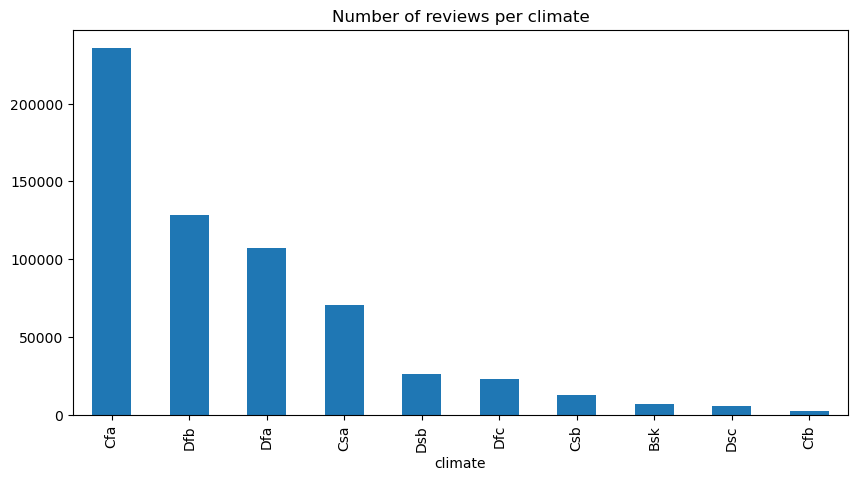

In [5]:
us_users_txt_rev.groupby("climate").count()["beer_id"].sort_values(ascending=False).plot(kind="bar", figsize=(10, 5), title="Number of reviews per climate")

Here we see that the datasets is quite imbalanced but we assumed that there is enough reviews to represent each climate.

## Ajectives analysis

Let's see if there is difference in what words people use to describe beers in function of the climate they live in.

In [6]:
adj_processed = True

try:
    with open("../data/us_users_txt_rev_adj_processed.csv", "rb") as f:
        us_users_txt_rev = pickle.load(f)
except FileNotFoundError:
    #load nlp model
    nlp = spacy.load("en_core_web_sm")
    adj = [[]]*len(us_users_txt_rev)

    for i in trange(len(us_users_txt_rev)):
        doc = nlp(us_users_txt_rev["text"].iloc[i])
        adj[i] = [token.text for token in doc if token.pos_ == "ADJ"]

    us_users_txt_rev["adj"] = adj
    
    with open("../data/us_users_txt_rev_adj_processed.csv", "wb") as f:
        pickle.dump(us_users_txt_rev, f)

In [7]:
us_users_txt_rev.head()

,beer_id,date,user_id,text,climate,language,scheme,seasonal_precipitation,heat_level,adj
0,19827,1360753200,brewdude1982.691169,This was a 12 oz bottle poured into a snifter....,Cfa,en,Temperate,without dry season,hot summer,"[dark, transparent, frothy, mild, low, best, a..."
1,19827,1357729200,agentmunky.409755,Poured from a 12 ounce bottle into a pilsner g...,Cfa,en,Temperate,without dry season,hot summer,"[creamy, clear, dark, Rich, brown, Slight, dry..."
2,19827,1353150000,ferrari29.320392,Beer poured from bottle into a Nonic shaped pi...,Dfa,en,Continental,without dry season,hot summer,"[Nonic, shaped, dark, brownish, colored, dark,..."
3,19827,1342260000,othershoe2.233642,Pours a rich brownish red with some chill haze...,Dfa,en,Continental,without dry season,hot summer,"[rich, brownish, big, white, little, bitter, b..."
4,19827,1335607200,brentk56.6284,Appearance: These Strangford Lough beers pour ...,Cfa,en,Temperate,without dry season,hot summer,"[clear, impressive, nice, huge, diacetyl, eart..."


In [8]:
climates = us_users_txt_rev["climate"].unique()

try:
    with open("../data/counts_climate.csv", "rb") as f:
        counts_climate = pickle.load(f)
    with open("../data/adj_climate.csv", "rb") as f:
        adj_climate = pickle.load(f)
except FileNotFoundError:
    #group adjectives by climate
    adj_climate = [[]]*len(climates)
    for i in range(len(climates)):
        us_users_txt_rev_climate = us_users_txt_rev[us_users_txt_rev["climate"]==climates[i]]
        for j in trange(len(us_users_txt_rev_climate)):       
            adj_climate[i] = adj_climate[i] + us_users_txt_rev_climate["adj"].iloc[j]
        for j in trange(len(adj_climate[i])):
            adj_climate[i][j] = adj_climate[i][j].lower()

    #counts for each words
    counts_climate = [pd.Series(adj_climate[i]).value_counts() for i in range(len(adj_climate))]

    with open("../data/counts_climate.csv", "wb") as f:
        pickle.dump(counts_climate, f)
    with open("../data/adj_climate.csv", "wb") as f:
        pickle.dump(adj_climate, f)

We plot the 50 most used adjectives by climate.

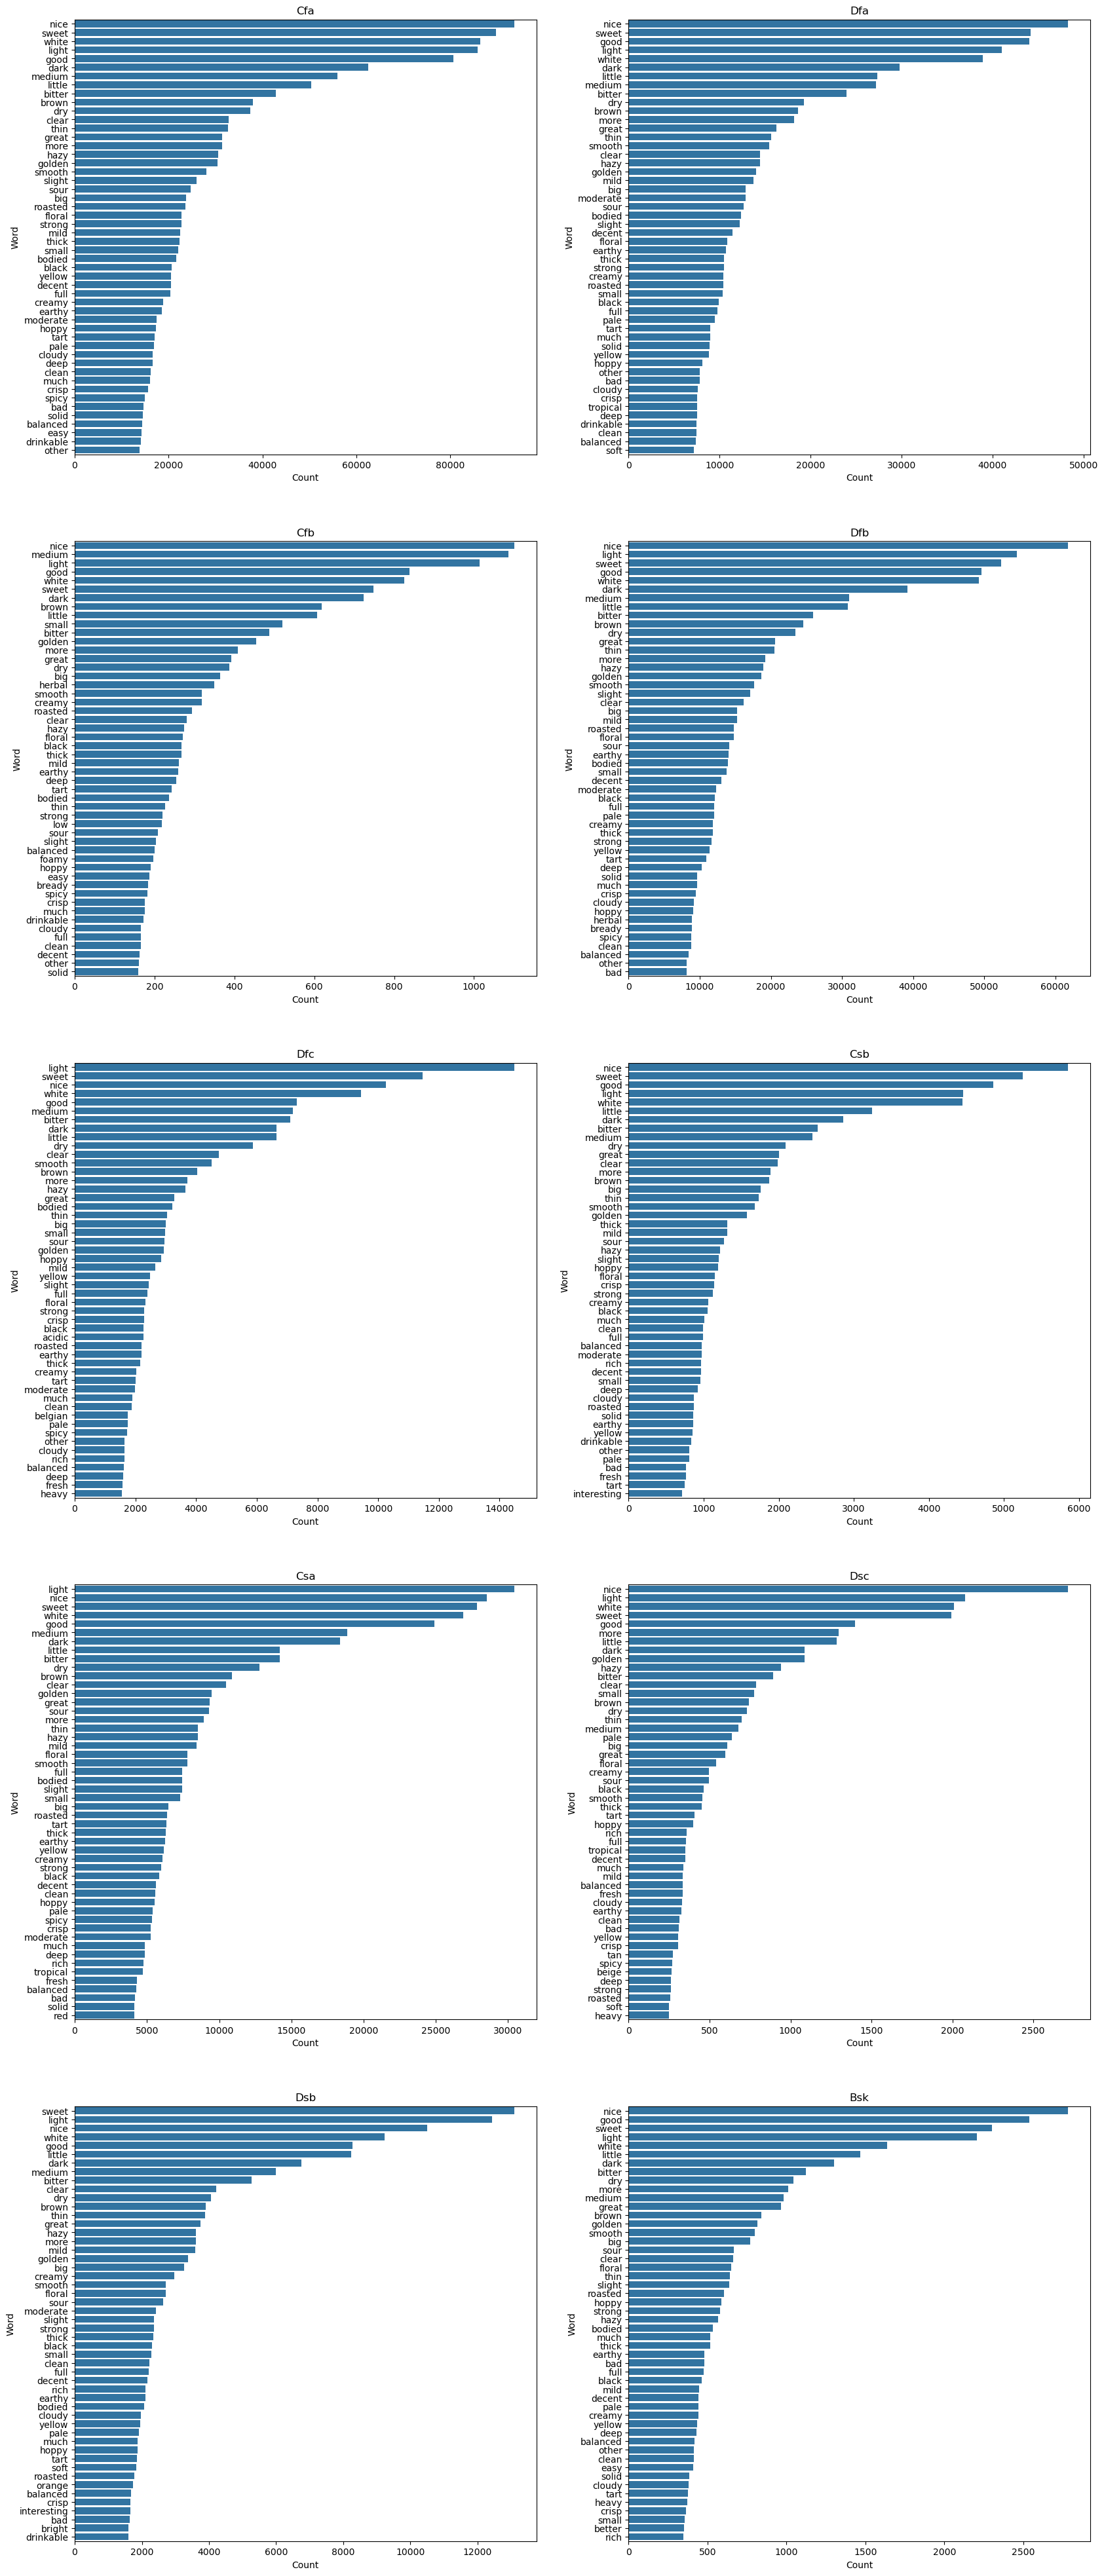

In [9]:
#plot counts of the 50 most common words for each climate
fig, axs = plt.subplots(5, 2, figsize=(20, 50))

for i in range(len(climates)):
    sns.barplot(y=counts_climate[i][:50].index, x=counts_climate[i][:50].values, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(climates[i])
    axs[i//2, i%2].set_xlabel("Count")
    axs[i//2, i%2].set_ylabel("Word")


We see that a lot of adjectives are in more than one climate. We will give less importance to the adjectives appearing in more climates.

In [10]:
#list of all the adjectives from the reviews
adj_all = []
for i in trange(len(adj_climate)):
    adj_all = adj_all + adj_climate[i]
    adj_all = list(set(adj_all))


100%|██████████| 10/10 [00:00<00:00, 13.05it/s]


Now we divide the number of times an adjective appears in one climate's review by the number of climates it appears in. This will give less importance to adjectives that appear in more climates, therefore giving more importance to rarer adjectives.

In [11]:
try:
    with open("../data/occurence.csv", "rb") as f:
        occurence = pickle.load(f)
except FileNotFoundError:
    #occurence matrix
    occurence = np.zeros((len(adj_all), len(climates)))

    for i in trange(len(adj_all)):
        for j in range(len(climates)):
            occurence[i, j] = 1 if adj_all[i] in adj_climate[j] else 0

    with open("../data/occurence.csv", "wb") as f:
        pickle.dump(occurence, f)

In [12]:
occurence_df = pd.DataFrame(occurence, index=adj_all, columns=climates)

In [13]:
try:
    with open("../data/counts_climate_tfidf.csv", "rb") as f:
        counts_climate = pickle.load(f)
except FileNotFoundError:
    for i in range(len(climates)):
        for j in trange(len(counts_climate[i])):
            all_counts = counts_climate[i].sum()
            for k in range(len(adj_all)):
                if counts_climate[i].index[j] == adj_all[k]:   
                    counts_climate[i].iloc[j] = counts_climate[i].iloc[j]/all_counts*np.log(len(climates)/occurence_df.loc[adj_all[k]].sum())

    with open("../data/counts_climate_tfidf.csv", "wb") as f:
        pickle.dump(counts_climate, f)

In [14]:
#sorting the adjectives by their counts
counts_climate = [counts_climate[i].sort_values(ascending=False) for i in range(len(counts_climate))]

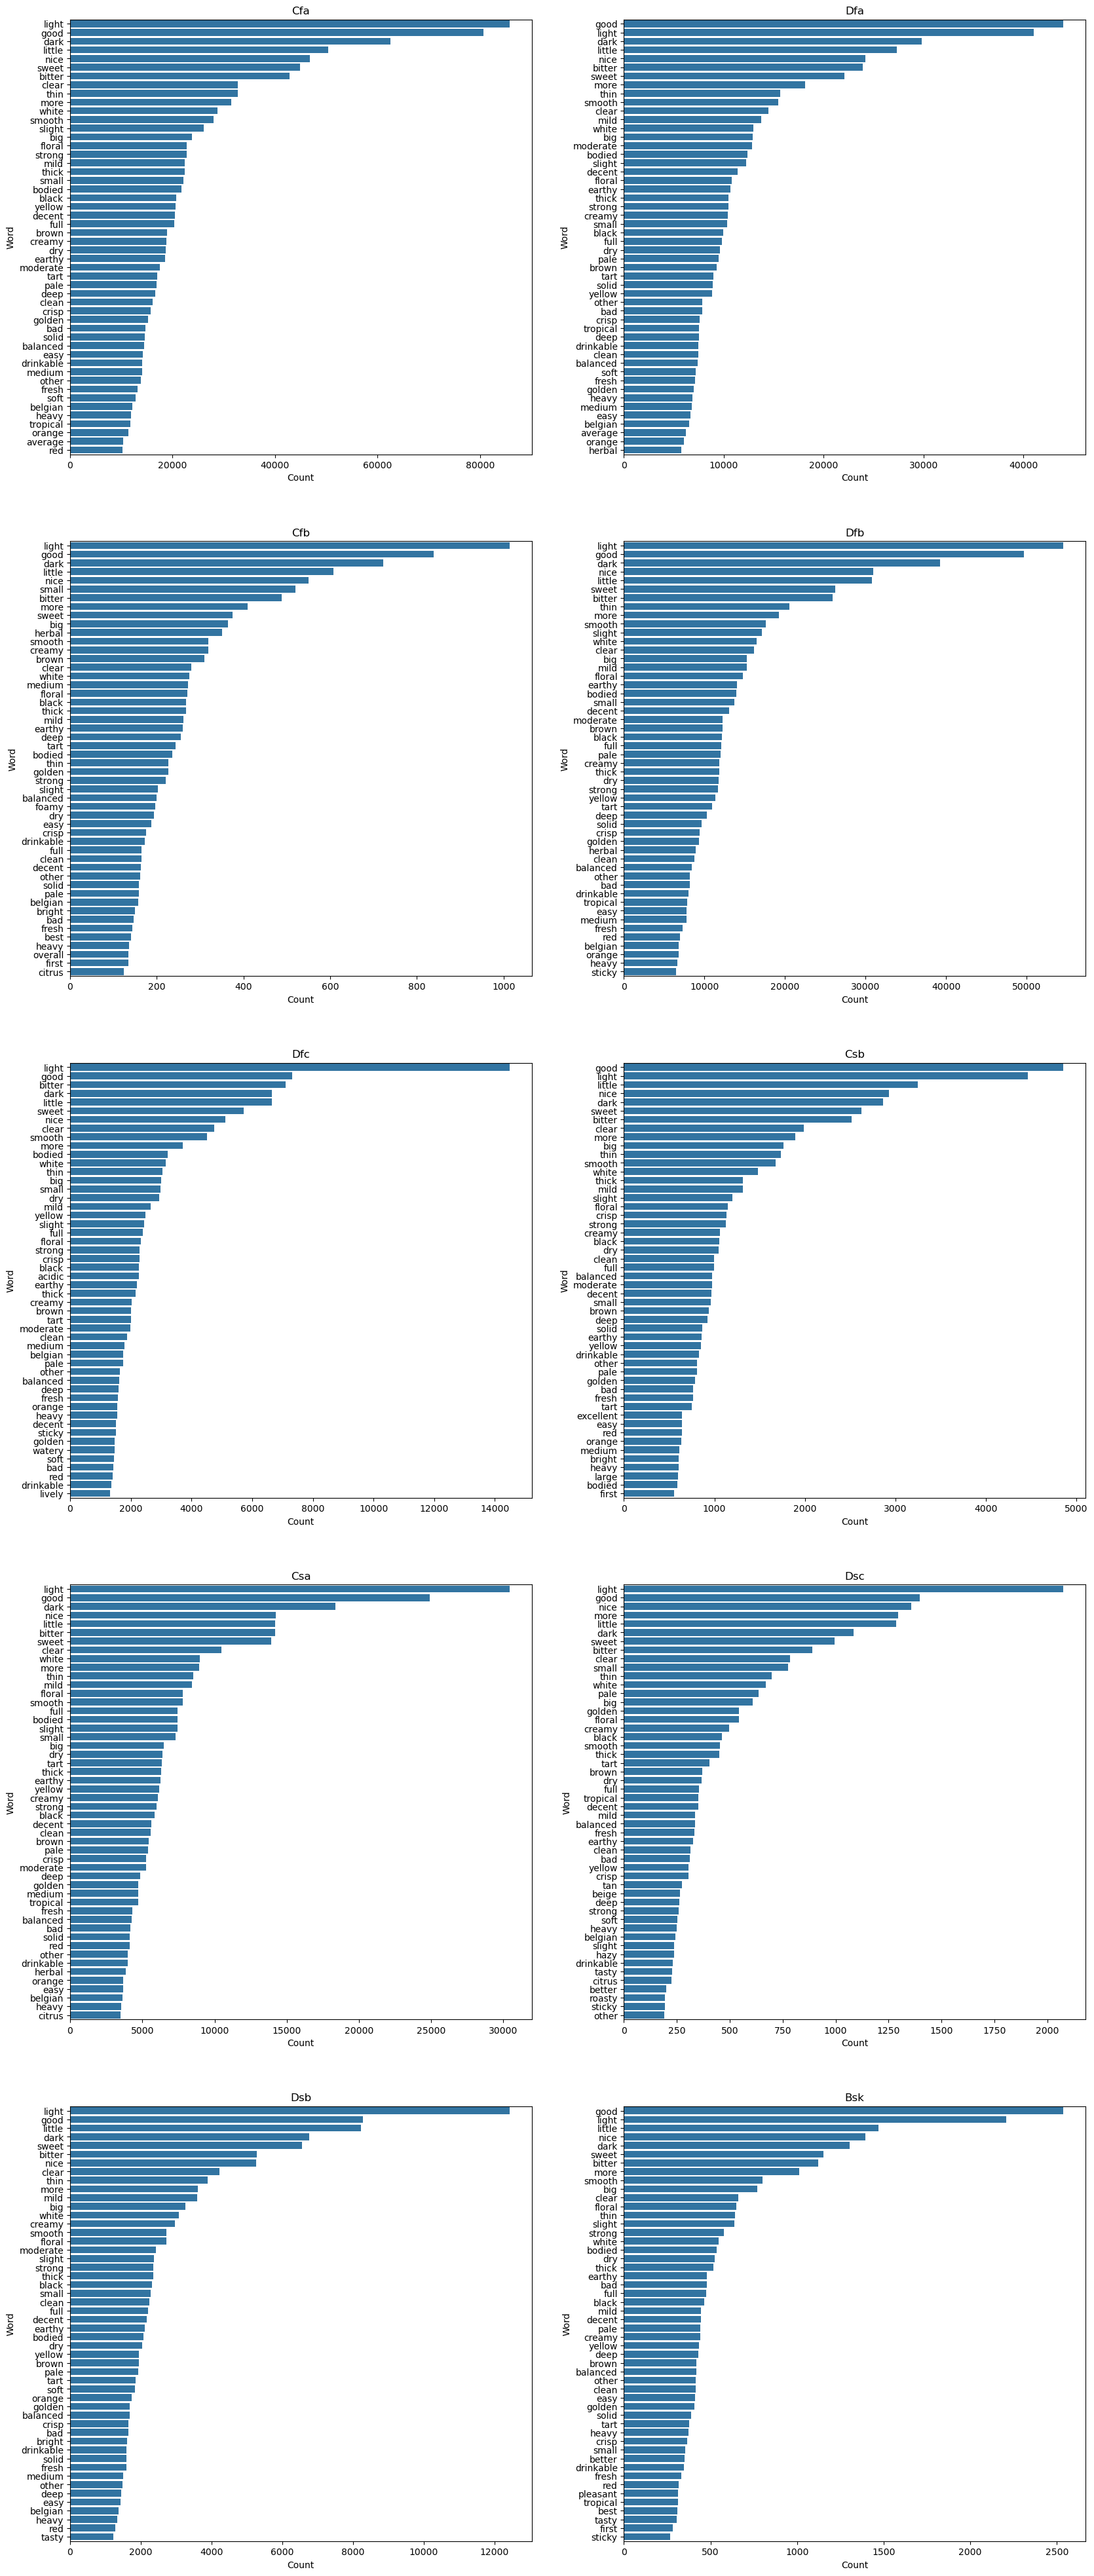

In [15]:
#plot counts of the 50 most common words for each climate after division by occurence
fig, axs = plt.subplots(5, 2, figsize=(20, 50))

for i in range(len(climates)):
    sns.barplot(y=counts_climate[i][:50].index, x=counts_climate[i][:50].values, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(climates[i])
    axs[i//2, i%2].set_xlabel("Count")
    axs[i//2, i%2].set_ylabel("Word")

To better visualize what adjectives are characteristic of each climate, we plot wordclouds with the most used adjectives by climate.

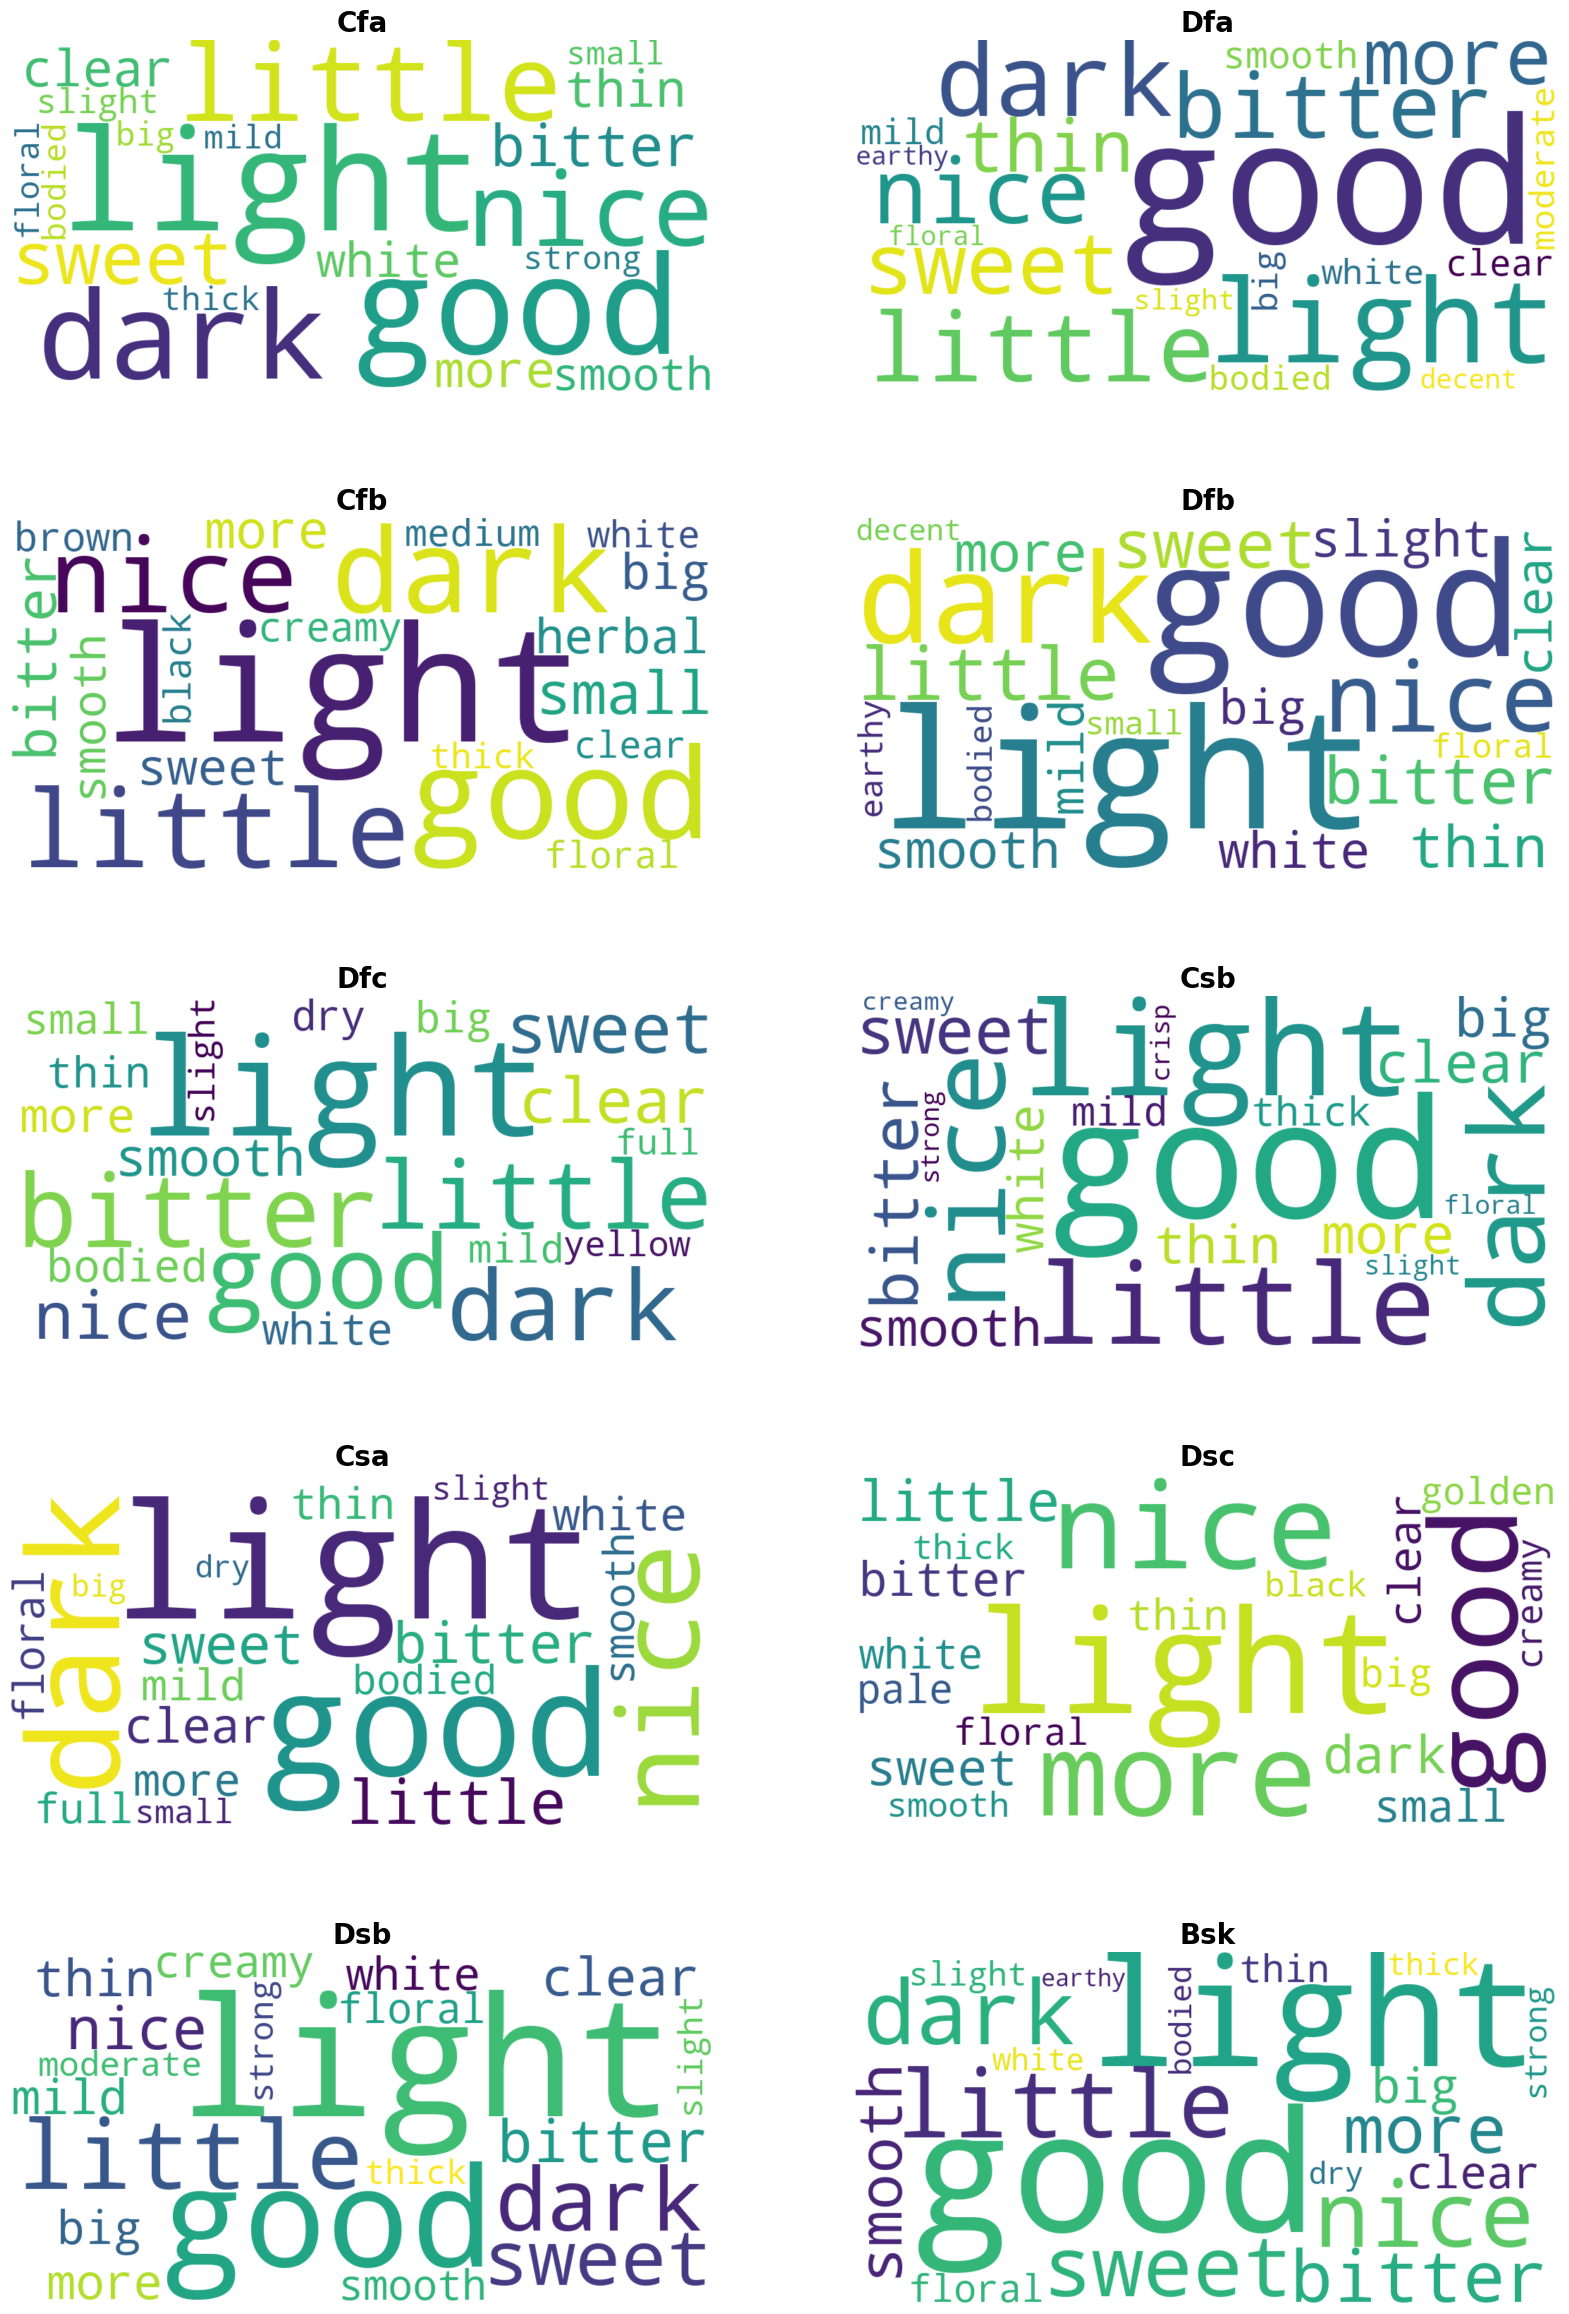

In [16]:
fig, axs = plt.subplots(5, 2, figsize=(20, 30))

for i in range(len(climates)):
    #create wordcloud
    wordcloud = WordCloud(background_color="white", width=1000, height=500).generate_from_frequencies(counts_climate[i][:20])
    axs[i//2, i%2].imshow(wordcloud, interpolation='bilinear')
    axs[i//2, i%2].axis("off")
    axs[i//2, i%2].set_title(climates[i], fontsize=20, weight="bold")

plt.show()

In [17]:
#save each wordcloud in separate png file

for i in range(len(climates)):
    wordcloud = WordCloud(background_color="white", width=1000, height=500).generate_from_frequencies(counts_climate[i][:20])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(climates[i], fontsize=20, weight="bold")
    plt.savefig("../data/wordclouds/"+climates[i]+".png")
    plt.close()

### Sentiment score analysis

Here we are testing if the sentiment score analysis changes depending on the climate. The sentiment score analysis is composed of two scores :
- polarity : Measures the positivity, negativity, or neutrality of sentiment in review. Ranges from -1 (very negative) to 1 (very positive).
- subjectivity : Measures how subjective or opinionated the review is. Ranges from 0 (highly objective) to 1 (highly subjective).

In [18]:
try:
    # Load the data
    us_users_txt_rev = pd.read_csv("../data/us_users_txt_rev_complete.csv", usecols=["beer_id", "date", "user_id", "climate", "climate_temperature", "climate_precipitation", "climate_scheme", "polarity", "subjectivity" ],
                                    dtype={"beer_id": "int32", "user_id": "str", "climate": "str", "climate_temperature": "str", "climate_precipitation": "str", "climate_scheme": "str", "polarity": "float", "subjectivity": "float"})
except FileNotFoundError:
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe('spacytextblob')
    polarity = [[]]*len(us_users_txt_rev)
    subjectivity = [[]]*len(us_users_txt_rev)

    for i in trange(len(us_users_txt_rev)):
        doc = nlp(us_users_txt_rev["text"].iloc[i])
        polarity[i] = doc._.blob.polarity
        subjectivity[i] = doc._.blob.subjectivity

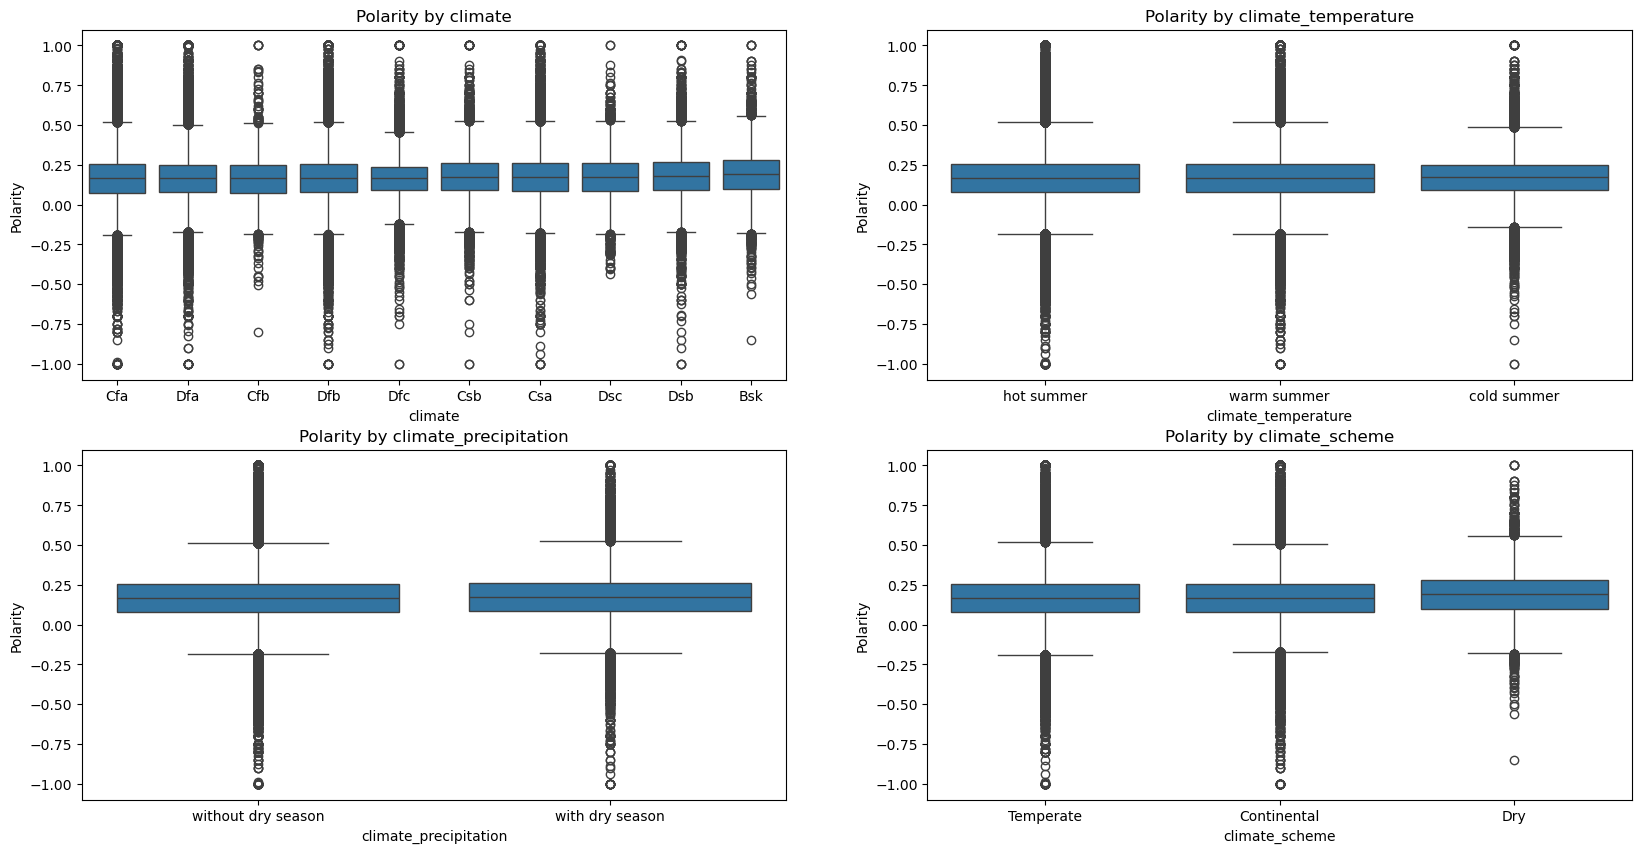

In [19]:
col = ["climate", "climate_temperature", "climate_precipitation", "climate_scheme"]

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i in range(len(col)):
    sns.boxplot(x=col[i], y="polarity", data=us_users_txt_rev, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title("Polarity by "+col[i])
    axs[i//2, i%2].set_xlabel(col[i])
    axs[i//2, i%2].set_ylabel("Polarity")


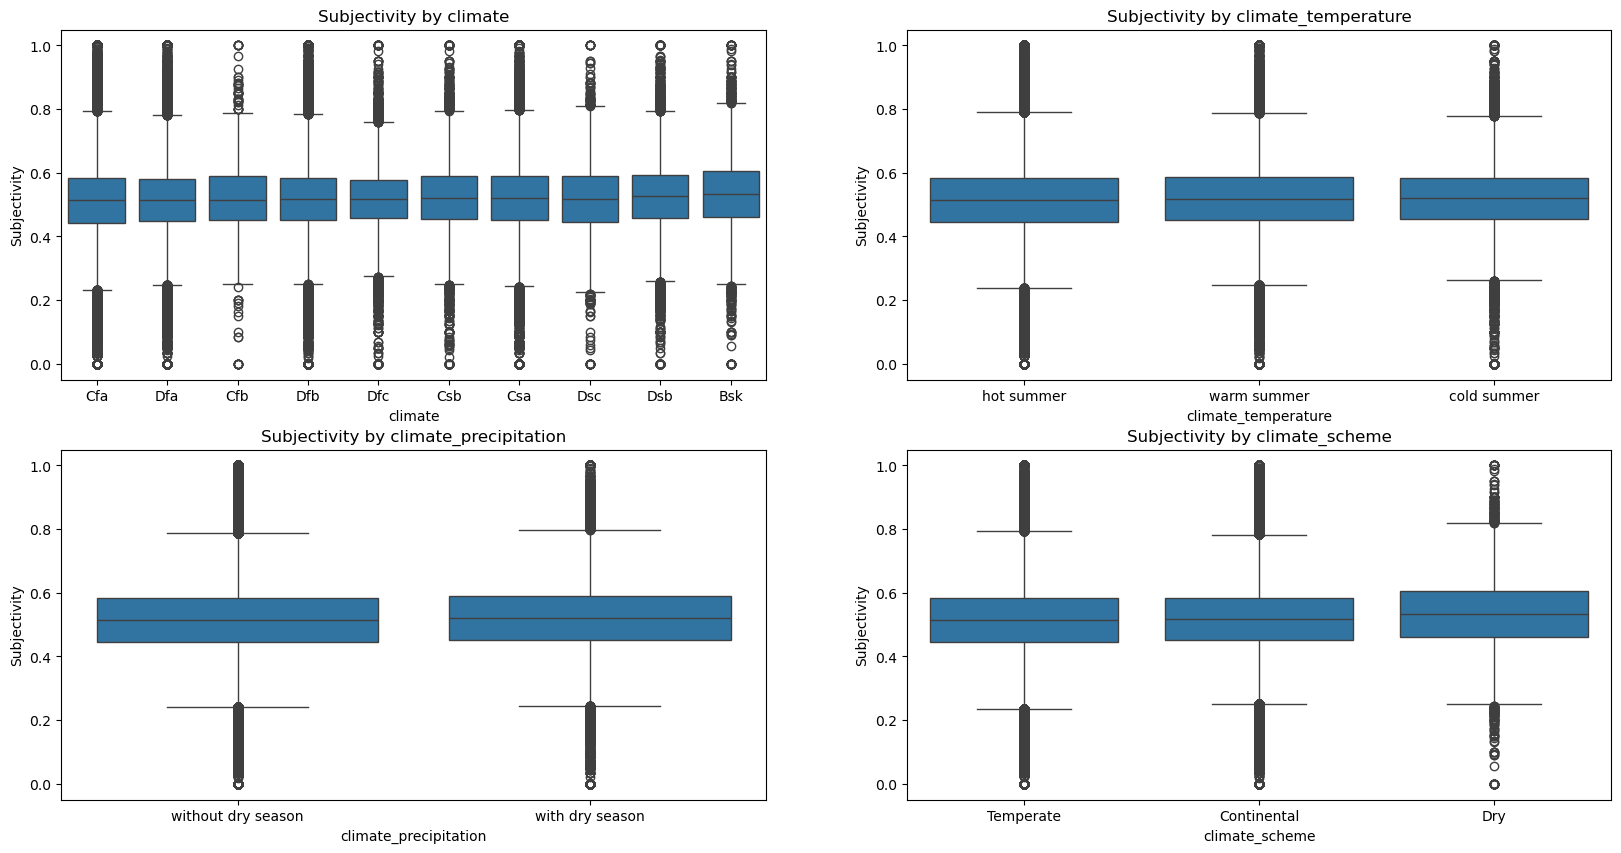

In [20]:
col = ["climate", "climate_temperature", "climate_precipitation", "climate_scheme"]

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i in range(len(col)):
    sns.boxplot(x=col[i], y="subjectivity", data=us_users_txt_rev, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title("Subjectivity by "+col[i])
    axs[i//2, i%2].set_xlabel(col[i])
    axs[i//2, i%2].set_ylabel("Subjectivity")


We can see that both the polarity and subjectivity does not change depending on the climate, nor the climate subgoup, as the plot don't show significant differences. It is not necessary to continue this analysis as it has already proven to be unconclusive.